# Importing Dependencies

In [1016]:
# Importing Necessary Libraries
#!pip install statsmodels==0.12.2

In [1017]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
from prophet import Prophet
from sklearn.svm import SVR

In [1018]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data and Preprocessing

In [1019]:
# Load the daily summary from a CSV file
daily_summary = pd.read_csv('/content/drive/MyDrive/daily_summary.csv')

# Data Preparation
# Convert date column to datetime format and set as index
daily_summary['date'] = pd.to_datetime(daily_summary['date'])
daily_summary.set_index('date', inplace=True)

# Handling missing values with interpolation
daily_summary['total_kWh_delivered'].interpolate(method='time', inplace=True)

# Outlier detection and treatment using z-score method
daily_summary = daily_summary[(np.abs(stats.zscore(daily_summary['total_kWh_delivered'])) < 3)]
daily_summary.drop("number_of_devices", inplace= True, axis=1)
daily_summary.head()

<ipython-input-1019-d5ecc47b06c9>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_summary['total_kWh_delivered'].interpolate(method='time', inplace=True)


,total_kWh_delivered
date,
2020-01-01,70.029000
2020-01-02,156.190000
2020-01-03,64.080000
2020-01-04,83.119000
2020-01-05,40.056395


In [1020]:
daily_summary.tail()

,total_kWh_delivered
date,
2021-09-08,262.802
2021-09-09,326.367
2021-09-11,193.040
2021-09-12,251.265
2021-09-14,45.064


# Stationarity Testing

In [1021]:
# Function to check for stationarity of the time series
def test_stationarity(timeseries):
    adf_result = adfuller(timeseries)
    kpss_result = kpss(timeseries)
    return adf_result[1], kpss_result[1]  # Return p-values

# Check for stationarity of the time series data
adf_p_value, kpss_p_value = test_stationarity(daily_summary['total_kWh_delivered'])
print(f"ADF p-value: {adf_p_value}")
print(f"KPSS p-value: {kpss_p_value}")

# Apply Diffrencing
if adf_p_value > 0.05 or kpss_p_value < 0.05:
    daily_summary['total_kWh_delivered'] = daily_summary['total_kWh_delivered'].diff().dropna()
daily_summary.head()

ADF p-value: 0.5131070274389952
KPSS p-value: 0.01


<ipython-input-1021-8c63f3c2737c>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


,total_kWh_delivered
date,
2020-01-01,NaN
2020-01-02,86.161000
2020-01-03,-92.110000
2020-01-04,19.039000
2020-01-05,-43.062605


In [1022]:
# Check rows with NaN values
nan_rows = daily_summary[daily_summary.isnull().any(axis=1)]
print(nan_rows)

# drop rows with NaN values
daily_summary.dropna(inplace=True)
print("NaN rows dropped.")

            total_kWh_delivered
date                           
2020-01-01                  NaN
NaN rows dropped.


# Lag Creation

In [1023]:
lagged_df = daily_summary.copy()

In [1024]:
# Feature Engineering: Create lag features and rolling statistics
for lag in range(1, 6):  # Create lag features
    lagged_df[f'lag_{lag}'] = lagged_df['total_kWh_delivered'].shift(lag)

lagged_df['rolling_mean'] = lagged_df['total_kWh_delivered'].rolling(window=7).mean()
lagged_df['rolling_std'] = lagged_df['total_kWh_delivered'].rolling(window=7).std()
lagged_df.dropna(inplace=True)  # Drop rows with NaN values

# Prepare features (X) and target variable (y)
X_lagged = lagged_df[['lag_1', 'lag_2', 'lag_3',
                      'lag_4', 'lag_5',
                      #'lag_6', 'lag_7',
                      #'lag_8', 'lag_9', 'lag_10',
                      'rolling_mean', 'rolling_std']]
y_lagged = lagged_df['total_kWh_delivered']
lagged_df.head(20)

,total_kWh_delivered,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,rolling_std
date,,,,,,,,
2020-01-08,-2.077000,29.131000,128.577605,-43.062605,19.039000,-92.110000,17.951286,74.447107
2020-01-09,54.063000,-2.077000,29.131000,128.577605,-43.062605,19.039000,13.365857,70.425538
2020-01-10,7.815000,54.063000,-2.077000,29.131000,128.577605,-43.062605,27.640857,53.600007
2020-01-11,-180.134000,7.815000,54.063000,-2.077000,29.131000,128.577605,-0.812429,95.452464
2020-01-12,-28.872000,-180.134000,7.815000,54.063000,-2.077000,29.131000,1.214801,94.552042
2020-01-14,265.250000,-28.872000,-180.134000,7.815000,54.063000,-2.077000,20.739429,131.950342
2020-01-15,103.120561,265.250000,-28.872000,-180.134000,7.815000,54.063000,31.309366,135.646307
2020-01-16,-83.113561,103.120561,265.250000,-28.872000,-180.134000,7.815000,19.732714,142.266973
2020-01-17,20.101000,-83.113561,103.120561,265.250000,-28.872000,-180.134000,14.881000,141.477997


# Divide Time Series Data into Training, Testing, and Validation Sets

- Training set: 2020-01-01 to 2021-03-31
- Testing set: 2021-04-01 to 2021-06-30
- Validation set: 2021-07-01 to 2021-09-14

In [1025]:
# Define the dates for splitting the data
train_end_date = '2021-03-31'
val_end_date = '2021-06-30'

In [1026]:
# Split the data into training, validation, and testing sets
X_train_lag = X_lagged.loc[:train_end_date]
y_train_lag = y_lagged.loc[:train_end_date]
X_test_lag = X_lagged.loc[train_end_date:val_end_date]
y_test_lag = y_lagged.loc[train_end_date:val_end_date]
X_val_lag = X_lagged.loc[val_end_date:]
y_val_lag = y_lagged.loc[val_end_date:]

In [1027]:
print(y_train_lag)

date
2020-01-08     -2.077
2020-01-09     54.063
2020-01-10      7.815
2020-01-11   -180.134
2020-01-12    -28.872
               ...   
2021-03-27   -140.626
2021-03-28     75.517
2021-03-29    -20.293
2021-03-30     27.508
2021-03-31    -98.698
Name: total_kWh_delivered, Length: 296, dtype: float64


In [1028]:
print("Values in training:", len(X_train_lag))
print("Values in testing:", len(X_test_lag))
print("Values in validation:", len(X_val_lag))

Values in training: 296
Values in testing: 92
Values in validation: 75


In [1029]:
# Splitting Data and Training Models
# Split data into training and testing sets using TimeSeriesSplit
#tscv = TimeSeriesSplit(n_splits=5)
#for train_index, test_index in tscv.split(X_lagged):
    #X_train_lag, X_test_lag = X_lagged.iloc[train_index], X_lagged.iloc[test_index]
    #y_train_lag, y_test_lag = y_lagged.iloc[train_index], y_lagged.iloc[test_index]

# Model Initialization and Evaluation Metrics Storage

In [1030]:
# Initialize lists to store metrics for each model across folds
rf_metrics_list = []
arima_metrics_list = []
lr_metrics_list = []
knn_metrics_list = []
prophet_metrics_list = []

## Random Forest

In [1031]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=1000, max_depth = 11, random_state=42)
rf_model.fit(X_train_lag, y_train_lag)
rf_forecast = rf_model.predict(X_test_lag)

# Evaluate Random Forest Model metrics
rf_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test_lag, rf_forecast)),
        'MSE': mean_squared_error(y_test_lag, rf_forecast),
        'MAE': mean_absolute_error(y_test_lag, rf_forecast)
    }
rf_metrics_list.append(rf_metrics)

In [1032]:
rf_forecast

array([-92.90466305,  39.23818519, -36.37874654,  -5.3376308 ,
       -62.46730694,  -8.86813211,  14.75413416, -17.44235914,
        13.60506271,  34.98736243, -84.07723687,  73.34991669,
         4.22301289,  39.09345007, -36.93240787,   3.38313612,
       -13.90453661, -24.67719705, -37.60323437,  13.21617505,
        -5.2107073 , -28.44869247,  -7.16364676,  19.95415296,
        54.85239559,  -7.6572513 ,  -9.73290405,  94.39448883,
       -72.50943031, -17.88640326, -78.3571454 , -42.69570187,
        -5.71505996,  10.37208342, -16.03476927, -23.2458973 ,
       -24.01599181,  -1.72096895, -65.51792889, -24.0803492 ,
       107.15568306,  14.03833017,  14.84279903,  46.46993661,
       -90.58246441, -20.53284706,  50.74415656,  39.29563116,
       -73.37019946, -14.63023977,  84.22938497,  -6.40906648,
       -66.24103094, -16.35303795,  -8.04708757,  41.89463505,
       -67.6192063 ,  63.91306242, -58.44808872,  34.00386439,
        34.22466286,   0.80520471,  -6.92058504,  34.66

In [1033]:
print("Metrics of Random Forest:")
print(rf_metrics_list)

Metrics of Random Forest:
[{'RMSE': 53.87346278525672, 'MSE': 2902.3499924744406, 'MAE': 45.27768503060493}]


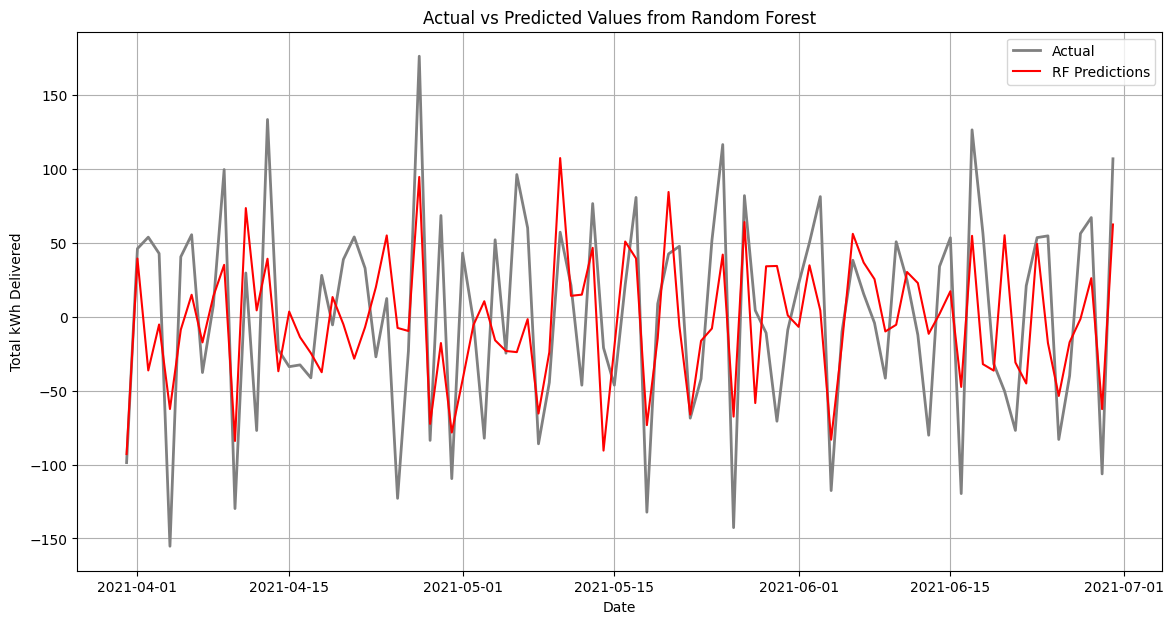

In [1034]:
# Plot actual kw values and forecast
plt.figure(figsize=(14, 7))
plt.plot(y_test_lag.index, y_test_lag, label='Actual', color='grey', linewidth=2)
plt.plot(y_test_lag.index, rf_forecast, label='RF Predictions', color='red')
plt.title('Actual vs Predicted Values from Random Forest')
plt.xlabel('Date')
plt.ylabel('Total kWh Delivered')
plt.legend()
plt.grid()
plt.show()

## Linear Regression

In [1035]:
# Used lagged data to fit a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lag, y_train_lag)
lr_forecast = lr_model.predict(X_test_lag)

# Evaluate Linear Regression Model metrics
lr_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test_lag, lr_forecast)),
        'MSE': mean_squared_error(y_test_lag, lr_forecast),
        'MAE': mean_absolute_error(y_test_lag, lr_forecast)
    }
lr_metrics_list.append(lr_metrics)

In [1036]:
# Print results
print("Metrics of Linear Regression:")
print(lr_metrics_list)

Metrics of Linear Regression:
[{'RMSE': 47.93388069163075, 'MSE': 2297.656918159491, 'MAE': 40.95899548392365}]


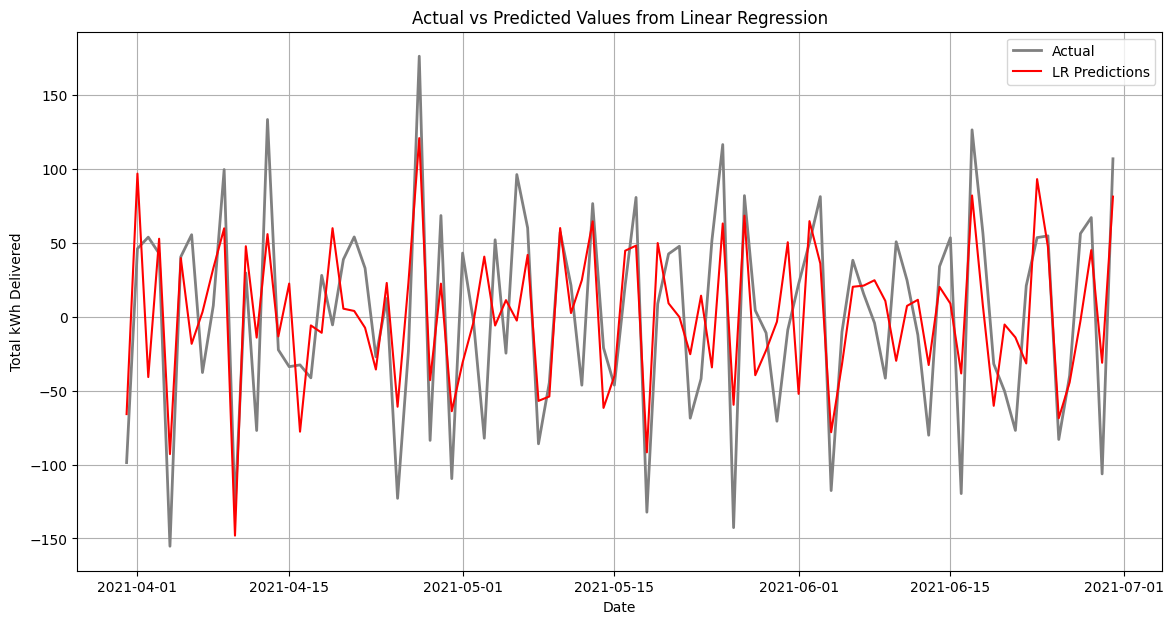

In [1037]:
# plot the actual and forecasted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_lag.index, y_test_lag, label='Actual', color='grey', linewidth=2)
plt.plot(y_test_lag.index, lr_forecast, label='LR Predictions', color='red')
plt.title('Actual vs Predicted Values from Linear Regression')
plt.xlabel('Date')
plt.ylabel('Total kWh Delivered')
plt.legend()
plt.grid()
plt.show()

## KNN

In [1038]:
# Create KNN model
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_lag, y_train_lag)

# Evaluate KNN
knn_forecast = knn_model.predict(X_test_lag)

knn_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test_lag, knn_forecast)),
        'MSE': mean_squared_error(y_test_lag, knn_forecast),
        'MAE': mean_absolute_error(y_test_lag, knn_forecast)
    }
knn_metrics_list.append(knn_metrics)

In [1039]:
# Print Results
print("Metrics of KNN:")
print(knn_metrics_list)

Metrics of KNN:
[{'RMSE': 63.727241551926745, 'MSE': 4061.1613158176187, 'MAE': 54.15838574212375}]


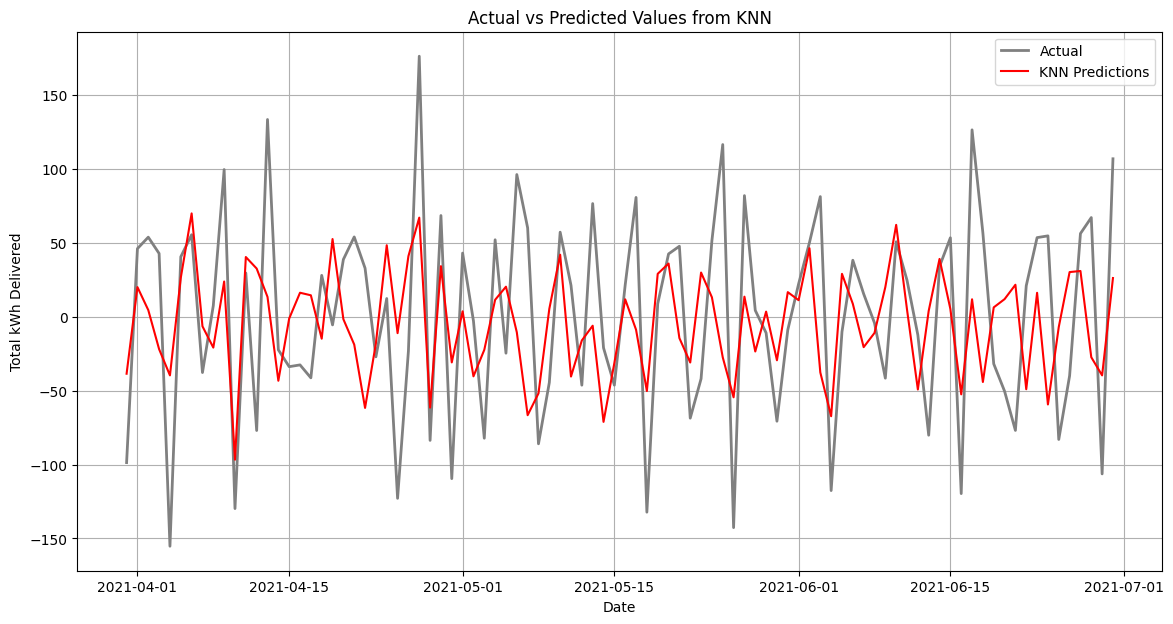

In [1040]:
# Plot the curve
plt.figure(figsize=(14, 7))
plt.plot(y_test_lag.index, y_test_lag, label='Actual', color='grey', linewidth=2)
plt.plot(y_test_lag.index, knn_forecast, label='KNN Predictions', color='red')
plt.title('Actual vs Predicted Values from KNN')
plt.xlabel('Date')
plt.ylabel('Total kWh Delivered')
plt.legend()
plt.grid()
plt.show()

## ARIMA

In [1041]:
# Capture original X and y from daily_summary dataframe
X = daily_summary.drop('total_kWh_delivered', axis=1)
y = daily_summary['total_kWh_delivered']

# Split data into training and testing sets using TimeSeriesSplit
#tscv = TimeSeriesSplit(n_splits=5)
#for train_index, test_index in tscv.split(X):
  #X_train, y_train = X.iloc[train_index], y.iloc[train_index]
  #X_test, y_test = X.iloc[test_index], y.iloc[test_index]

In [1042]:
# Divide based on dates as above
X_train = X.loc[:train_end_date]
y_train = y.loc[:train_end_date]
X_test = X.loc[train_end_date:val_end_date]
y_test = y.loc[train_end_date:val_end_date]
X_val = X.loc[val_end_date:]
y_val = y.loc[val_end_date:]

In [1043]:
print("Values in training:", len(X_train))
print("Values in testing:", len(X_test))
print("Values in validation:", len(X_val))

Values in training: 302
Values in testing: 92
Values in validation: 75


In [1044]:
# ARIMA Model fitting and forecasting
arima_model = ARIMA(y_train, order=(3, 1, 3))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(y_test))

# Evaluate ARIMA Model metrics
arima_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, arima_forecast)),
        'MSE': mean_squared_error(y_test, arima_forecast),
        'MAE': mean_absolute_error(y_test, arima_forecast)
    }
arima_metrics_list.append(arima_metrics)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

In [1045]:
print(arima_forecast)

302    40.484761
303    17.666696
304   -29.670472
305    -2.190654
306    31.918444
         ...    
389     0.109065
390    -0.042363
391     0.106861
392     0.128708
393    -0.017601
Name: predicted_mean, Length: 92, dtype: float64


In [1046]:
print("Metrics of ARIMA:")
print(arima_metrics_list)

Metrics of ARIMA:
[{'RMSE': 72.11623546477237, 'MSE': 5200.751417610492, 'MAE': 59.980262632725015}]


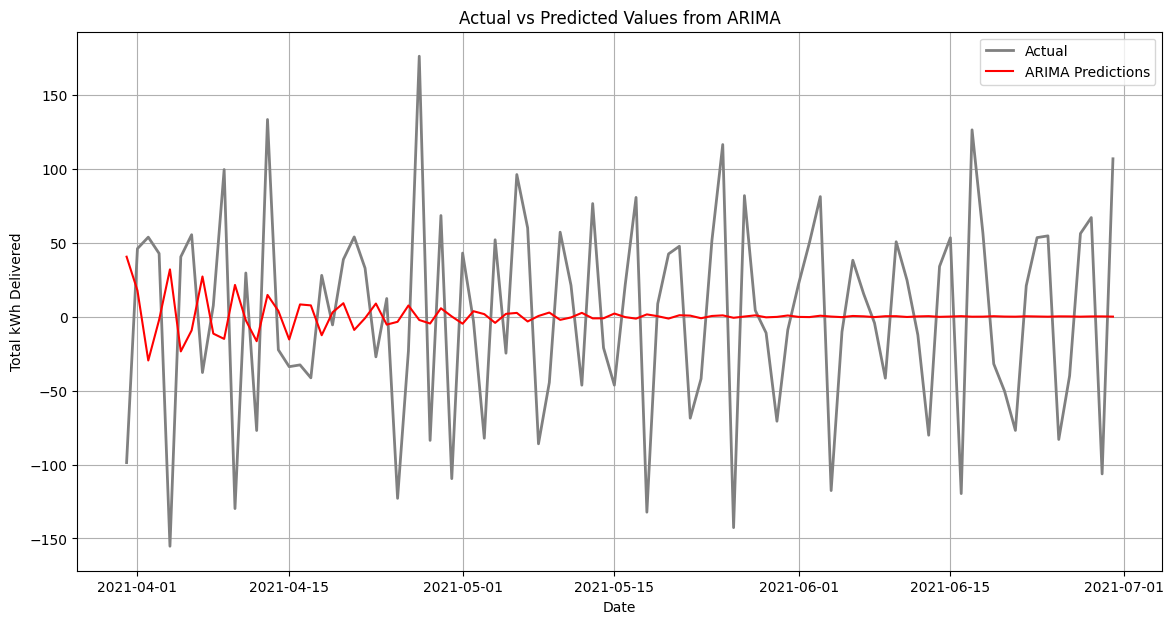

In [1047]:
# Plot actual kw values and forecast of ARIMA
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='grey', linewidth=2)
plt.plot(y_test.index, arima_forecast, label='ARIMA Predictions', color='red')
plt.title('Actual vs Predicted Values from ARIMA')
plt.xlabel('Date')
plt.ylabel('Total kWh Delivered')
plt.legend()
plt.grid()
plt.show()

## Prophet Model

In [1048]:
# Prepare data for Prophet model (Prophet requires a specific format)
prophet_df_train = pd.DataFrame({
        'ds': y_train.index,
        'y': y_train.values
    })

In [1049]:
# Fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcf9_ejx9/zkpuimpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcf9_ejx9/mhe3ngxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48100', 'data', 'file=/tmp/tmpcf9_ejx9/zkpuimpe.json', 'init=/tmp/tmpcf9_ejx9/mhe3ngxu.json', 'output', 'file=/tmp/tmpcf9_ejx9/prophet_modelyn9ltifq/prophet_model-20241218132740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:27:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:27:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [1050]:
#Create future dataframe for predictions (length of test set)
future_dates = prophet_model.make_future_dataframe(periods=len(y_test))

# Make predictions with Prophet model
prophet_forecast = prophet_model.predict(future_dates)

# Extracting predictions for the test period only
prophet_y_pred = prophet_forecast[-len(y_test):]['yhat'].values

# Evaluate Prophet Model Metrics
prophet_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test.values, prophet_y_pred)),
        'MSE': mean_squared_error(y_test.values, prophet_y_pred),
        'MAE': mean_absolute_error(y_test.values, prophet_y_pred)
    }

prophet_metrics_list.append(prophet_metrics)

In [1051]:
# Print results
print("Metrics of Prophet:")
print(prophet_metrics_list)

Metrics of Prophet:
[{'RMSE': 73.79362523958658, 'MSE': 5445.499126000549, 'MAE': 60.40737510212049}]


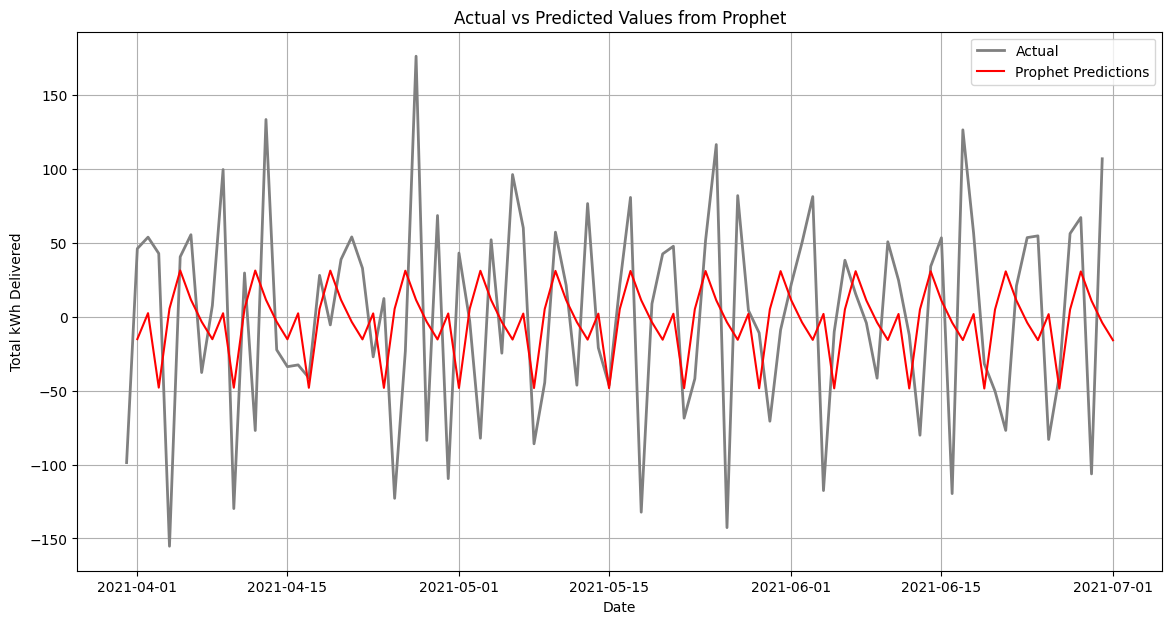

In [1052]:
# Plot the predicitons against actual
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='grey', linewidth=2)
plt.plot(prophet_forecast[-len(y_test):]['ds'], prophet_forecast[-len(y_test):]['yhat'], label='Prophet Predictions', color='red')
plt.title('Actual vs Predicted Values from Prophet')
plt.xlabel('Date')
plt.ylabel('Total kWh Delivered')
plt.legend()
plt.grid()
plt.show()

# Comaprison of all Models

In [1053]:
# Create dataframe for comparison
model_names = ['Random Forest', 'Linear Regression', 'KNN', 'ARIMA', 'Prophet']
metrics_list = [rf_metrics, lr_metrics, knn_metrics, arima_metrics, prophet_metrics]

result_df = pd.DataFrame(metrics_list, index=model_names)

# Round off values to 4 decimal places
result_df = result_df.round(6)

In [1054]:
# Display the result dataframe
result_df

,RMSE,MSE,MAE
Random Forest,53.873463,2902.349992,45.277685
Linear Regression,47.933881,2297.656918,40.958995
KNN,63.727242,4061.161316,54.158386
ARIMA,72.116235,5200.751418,59.980263
Prophet,73.793625,5445.499126,60.407375


From the comparison table above, ML models have outperformed the state of the art Prophet model and the conventional ARIMA model.

In [1055]:
# Save as CSV file
result_df.to_csv('model_metrics.csv')

# Save models using Pickle library

In [1056]:
import pickle

# Save the Random Forest model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save Linear Regression model
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Save KNN model
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)

# Save ARIMA model
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(arima_fit, f)

# Save Prophet model
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)

# Forecasting for 75 days with validation set

In [1057]:
# Forecasting into future 75 days with Random Forest, Linear Regression, KNN models using validation data

# Create a dataframe to store the forecasted values
forecasts = pd.DataFrame(columns=['Random Forest', 'Linear Regression', 'KNN'])

# Create date range 2021-07-01 to 2021-09-14
futuredates = pd.date_range(start='2021-07-02', end='2021-09-14')

# Random Forest Model
future_rf = rf_model.predict(X_val_lag)
forecasts['Random Forest'] = future_rf

# Linear Regression Model
future_lr = lr_model.predict(X_val_lag)
forecasts['Linear Regression'] = future_lr

# KNN Model
future_knn = knn_model.predict(X_val_lag)
forecasts['KNN'] = future_knn

forecasts

,Random Forest,Linear Regression,KNN
0,62.252959,81.107690,26.055000
1,-35.421340,-20.042341,-51.688600
2,-80.066671,-101.956053,6.230200
3,77.466090,53.570105,-16.815000
4,24.179144,33.630257,80.235200
...,...,...,...
70,15.773232,40.656851,12.971000
71,-20.722790,16.802012,-38.226400
72,-82.186251,-85.990760,-36.673324
73,64.051857,39.480197,39.823600


In [1058]:
# Get forecast for future_dates from ARIMA and Prophet

# ARIMA forecast
future_arima = arima_fit.forecast(steps=len(y_val))
forecasts['ARIMA'] = future_arima.values

# Prophet forecast
#Create future dataframe for predictions (length of val set)
future_dates = prophet_model.make_future_dataframe(periods=len(y_val))

# Make predictions with Prophet model
prophet_forecast_future = prophet_model.predict(future_dates)

print(len(prophet_forecast_future))

# Extracting predictions for the test period only
prophet_y_pred_future = prophet_forecast_future[-len(y_test):]['yhat'].values

# save first 75 values only
forecasts['Prophet'] = prophet_y_pred_future[:75]

forecasts

377


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Random Forest,Linear Regression,KNN,ARIMA,Prophet
0,62.252959,81.107690,26.055000,40.484761,31.345736
1,-35.421340,-20.042341,-51.688600,17.666696,11.584076
2,-80.066671,-101.956053,6.230200,-29.670472,-3.299977
3,77.466090,53.570105,-16.815000,-2.190654,-15.125589
4,24.179144,33.630257,80.235200,31.918444,2.431933
...,...,...,...,...,...
70,15.773232,40.656851,12.971000,0.258944,30.786823
71,-20.722790,16.802012,-38.226400,0.262857,11.025163
72,-82.186251,-85.990760,-36.673324,-0.249372,-3.858890
73,64.051857,39.480197,39.823600,0.125643,-15.684502


In [1059]:
# Save forecasts in csv file
forecasts.to_csv('val_set_forecasts.csv')

In [1060]:
print(len(futuredates))

75


In [1061]:
# Make the future dates as index of forecasts dataframe
forecasts.index = futuredates

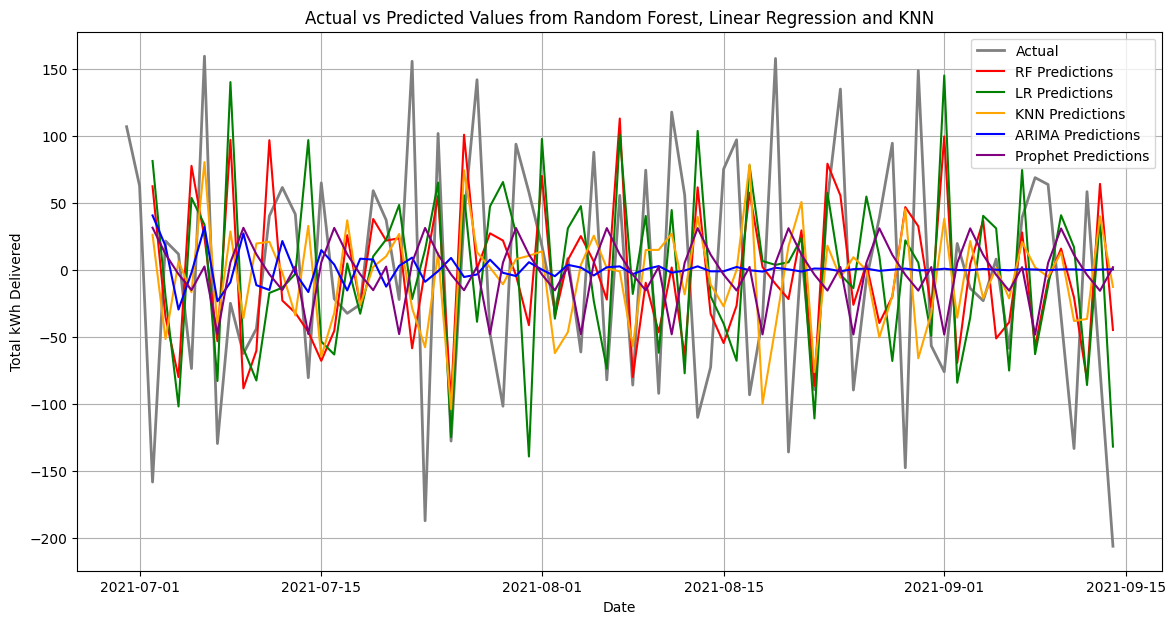

In [1062]:
# Plotting forecasted future values on the curve with actual values
plt.figure(figsize=(14, 7))
plt.plot(y_val_lag.index, y_val_lag, label='Actual', color='grey', linewidth=2)
plt.plot(forecasts.index, forecasts['Random Forest'], label='RF Predictions', color='red')
plt.plot(forecasts.index, forecasts['Linear Regression'], label='LR Predictions', color='green')
plt.plot(forecasts.index, forecasts['KNN'], label='KNN Predictions', color='orange')
plt.plot(forecasts.index, forecasts['ARIMA'], label='ARIMA Predictions', color='blue')
plt.plot(forecasts.index, forecasts['Prophet'], label='Prophet Predictions', color='purple')
plt.title('Actual vs Predicted Values from Random Forest, Linear Regression and KNN')
plt.xlabel('Date')
plt.ylabel('Total kWh Delivered')
plt.legend()
plt.grid()
plt.show()